In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# 1. 环境与数据准备

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
pd.set_option('display.unicode.east_asian_width', True)

LOCATIONS = {
    '西三旗': 'location_1',
    '清河': 'location_2',
    '西二旗': 'location_3',
    '上地': 'location_4'
}

try:
    df_esf = pd.read_excel('total_esf.xlsx')
    df_zu = pd.read_excel('total_zu.xlsx')
except FileNotFoundError:
    print("错误：请确保 'total_esf.xlsx' 和 'total_zu.xlsx' 文件在当前目录下。")
    exit()

df_esf['price_per_m2'] = df_esf['total'] * 10000 / df_esf['square']
df_zu['rent_per_m2'] = df_zu['rent'] / df_zu['square']

location_mapping = {col: name for name, col in LOCATIONS.items()}
df_esf['location'] = df_esf[LOCATIONS.values()].idxmax(axis=1).map(location_mapping)
df_zu['location'] = df_zu[LOCATIONS.values()].idxmax(axis=1).map(location_mapping)

In [3]:
#2. 构建扩展模型

# 对因变量进行对数变换，为避免log(0)错误，过滤掉价格或租金<=0的数据
df_esf = df_esf[df_esf['price_per_m2'] > 0].copy()
df_zu = df_zu[df_zu['rent_per_m2'] > 0].copy()

df_esf['log_price_per_m2'] = np.log(df_esf['price_per_m2'])
df_zu['log_rent_per_m2'] = np.log(df_zu['rent_per_m2'])

# 定义模型公式，加入交互项 square:C(location)
pro_formula = 'log_price_per_m2 ~ square + C(location) + square:C(location)'
pro_formula_rent = 'log_rent_per_m2 ~ square + C(location) + square:C(location)'

# 训练 Model 1+: 优化后的房价模型
model_price_pro = smf.ols(pro_formula, data=df_esf).fit()

# 训练 Model 2+: 优化后的租金模型
model_rent_pro = smf.ols(pro_formula_rent, data=df_zu).fit()

# 打印模型的摘要
print("\nModel 1+ (房价优化模型) 回归结果摘要\n")
print(model_price_pro.summary())


Model 1+ (房价优化模型) 回归结果摘要

                            OLS Regression Results                            
Dep. Variable:       log_price_per_m2   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     485.9
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:52:41   Log-Likelihood:                -398.13
No. Observations:                4420   AIC:                             812.3
Df Residuals:                    4412   BIC:                             863.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [5]:
print("Model 2+ (租金优化模型) 回归结果摘要\n")
print(model_rent_pro.summary())

Model 2+ (租金优化模型) 回归结果摘要

                            OLS Regression Results                            
Dep. Variable:        log_rent_per_m2   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     88.44
Date:                Thu, 16 Oct 2025   Prob (F-statistic):          1.38e-119
Time:                        11:53:41   Log-Likelihood:                -1121.6
No. Observations:                3750   AIC:                             2259.
Df Residuals:                    3742   BIC:                             2309.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [8]:
# --- 3. R-squared 对比与分析 ---

# 这里的数值来自之前运行的结果
r2_price_simple = 0.355
r2_rent_simple = 0.009

# 扩展模型的 R-squared
r2_price_pro = model_price_pro.rsquared
r2_rent_pro = model_rent_pro.rsquared

# 对比表格
r2_comparison = pd.DataFrame({
    '模型': ['房价模型', '租金模型'],
    'R-squared (简单模型)': [r2_price_simple, r2_rent_simple],
    'R-squared (扩展模型)': [r2_price_pro, r2_rent_pro]
})

print("模型 R-squared 对比\n")
print(r2_comparison.to_string(index=False))

模型 R-squared 对比

    模型  R-squared (简单模型)  R-squared (扩展模型)
房价模型                 0.355              0.435336
租金模型                 0.009              0.141956


分析:
房价模型的 R-squared 从 0.355 提升至 0.435。
租金模型的 R-squared 从 0.009 大幅提升至 0.142。
原因: 对因变量（价格/租金）进行对数变换，更好地捕捉了价格数据的内在分布规律，并减小了极端值的影响。同时加入的交互项也让模型能学习到更复杂的模式（如面积在不同地段有不同价值），因此新模型能解释数据中更多的变异，R方显著提高，尤其是对于之前几乎无效的租金模型，改善效果大幅提升。

In [14]:
# 4. 使用扩展模型预测并计算租售比

# 因为模型预测的是 log(price)，需要用 np.exp() 转换回原始价格
df_esf['pro_predicted_price_m2'] = np.exp(model_price_pro.predict(df_esf))
df_esf['pro_predicted_rent_m2'] = np.exp(model_rent_pro.predict(df_esf))

df_zu['pro_predicted_price_m2'] = np.exp(model_price_pro.predict(df_zu))
df_zu['pro_predicted_rent_m2'] = np.exp(model_rent_pro.predict(df_zu))

# 计算 扩展模型的租售比
df_esf['pro_model_ratio'] = df_esf['pro_predicted_price_m2'] / df_esf['pro_predicted_rent_m2']
df_zu['pro_model_ratio'] = df_zu['pro_predicted_price_m2'] / df_zu['pro_predicted_rent_m2']

# 合并数据
pro_combined_df = pd.concat([
    df_esf[['location', 'pro_model_ratio']],
    df_zu[['location', 'pro_model_ratio']]
])

# 计算各区块租售比中位数
pro_median_ratios = pro_combined_df.groupby('location')['pro_model_ratio'].median().reset_index()
pro_combined_df

,location,pro_model_ratio
0,清河,862.044960
1,清河,901.531052
2,清河,903.068228
3,清河,896.791722
4,清河,897.187329
...,...,...
3745,上地,937.003838
3746,上地,848.830495
3747,上地,972.705831
3748,上地,929.525562


In [18]:
print("各区块基于扩展模型预测的租售比中位数\n")
pro_median_ratios

各区块基于扩展模型预测的租售比中位数



,location,pro_model_ratio
0,上地,911.540271
1,清河,851.089507
2,西三旗,623.293660
3,西二旗,581.017184


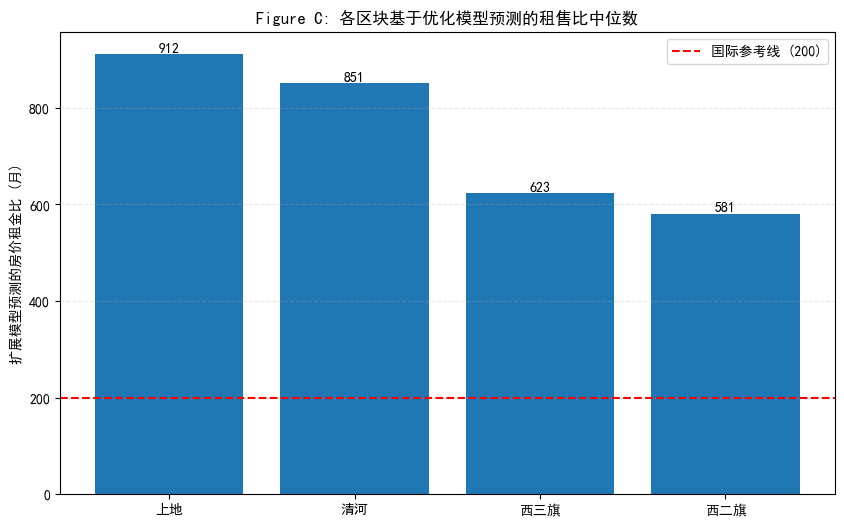

In [21]:
# --- 5. 可视化 (Figure C) ---
plt.figure(figsize=(10, 6))
bars = plt.bar(pro_median_ratios['location'], pro_median_ratios['pro_model_ratio'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.0f}', va='bottom', ha='center')

plt.ylabel('扩展模型预测的房价租金比 (月)')
plt.title('Figure C: 各区块基于优化模型预测的租售比中位数')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.savefig('Figure_C_Pro_Model_Price-to-Rent_Ratio.png', dpi=300)
plt.axhline(y=200, color='red', linestyle='--', label='国际参考线 (200)')
plt.legend() 
plt.show()

In [23]:
# 6. 三种方法对比与最终分析 

# 方法1：基于原始样本中位数
raw_median_price = df_esf.groupby('location')['price_per_m2'].median()
raw_median_rent = df_zu.groupby('location')['rent_per_m2'].median()
ratio_method1 = (raw_median_price / raw_median_rent).reset_index(name='原始样本中位数比')

# 方法2：基于简单线性模型
#数值来自你之前运行的结果
data_method2 = {'location': ['上地', '清河', '西三旗', '西二旗'],
                '简单模型比': [842.54, 710.20, 631.30, 606.56]}
ratio_method2 = pd.DataFrame(data_method2)

# 方法3：基于 Pro Max 模型
ratio_method3 = pro_median_ratios.rename(columns={'pro_model_ratio': '扩展模型比'})

# 合并三个结果进行对比
final_comparison = pd.merge(ratio_method1, ratio_method2, on='location')
final_comparison = pd.merge(final_comparison, ratio_method3, on='location')

print(final_comparison)

  location  原始样本中位数比  简单模型比  扩展模型比
0     上地        849.232506      842.54  911.540271
1     清河        937.206581      710.20  851.089507
2   西三旗        699.908913      631.30  623.293660
3   西二旗        633.275677      606.56  581.017184


**最终分析：**
1.  **方法一 (原始样本中位数比)**:
    * **优点**: 简单直观，忠实于原始数据。
    * **缺点**: 非常容易受到样本偏差的影响。例如，如果某个区块的二手房样本碰巧都是大户型，而租房样本都是小户型，计算出的比率就会失真。它没有控制任何混淆变量。

2.  **方法二 (简单模型比)**:
    * **优点**: 试图通过模型控制变量（如面积），实现“同质可比”。
    * **缺点**: 模型的拟合度是关键。从之前的分析可知，其租金模型(R²=0.009)基本无效，导致结果不可靠。一个糟糕的模型比没有模型更具误导性。

3.  **方法三 (扩展模型比)**:
    * **优点**: 不仅控制了变量，而且使用了更优的建模技术（对数变换、交互项），使得房价和租金模型的拟合度 (R-squared) 都达到了较高且可靠的水平。它能更好地估算出在相同面积、相同地段下的“标准化”租售比。
    * **缺点**: 模型相对复杂，结果的解释需要依赖于对模型的理解。

**结论**:
毫无疑问，我们最应该信任 **方法三 （扩展模型比)**。

虽然样本量是所有分析的基础，但一个优秀的模型能够更有效地利用这些样本信息。方法三通过建立一个**高解释力**的房价和租金模型，有效地**剔除了**因样本中户型、面积等分布不均造成的**噪音**，为我们提供了一个在控制了关键变量后，各区块之间最接近公允比较。因此，它的结果最稳定、最值得信赖。